## Notebook under construction

# MNIST digit classification before and after shuffling


* You train different NNs  with different architectures and on different versions of the data set to classify the 10 digits in the mnist data set.

To check if the local order of the pixels within the images have an impact on the classification performance, you do a permutations experiment: 
* You train the NN once on the original data and once after shuffling the order of the pixel values.
* As architecture for the NN you use first a fcNN and then a CNN



<a href="https://colab.research.google.com/github/tensorchiefs/dl_book/blob/master/chapter_02/edge-lover-simple-cnn.ipynb"> <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="open in colab">
</a>
| [open in colab](https://colab.research.google.com/github/tensorchiefs/dl_book/blob/master/chapter_02/mnist_permutation_fcNN_CNN.ipynb)



### Loading the required libraries

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation  
from keras.layers import Convolution2D, MaxPooling2D, Flatten
import keras
import sys
print ("Keras {} TF {} Python {}".format(keras.__version__, tf.__version__, sys.version_info))
!date

Using TensorFlow backend.


Keras 2.2.2 TF 1.10.1 Python sys.version_info(major=3, minor=5, micro=2, releaselevel='final', serial=0)
Thu Dec 13 13:03:27 UTC 2018


### Loading and preparing the MNIST data

In [2]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# separate x_train in X_train and X_val, same for y_train
X_train=x_train[0:50000] / 255 #divide by 255 so that they are in range 0 to 1
Y_train=keras.utils.to_categorical(y_train[0:50000],10) # one-hot encoding

X_val=x_train[50000:60000] / 255
Y_val=keras.utils.to_categorical(y_train[50000:60000],10)

X_test=x_test / 255
Y_test=keras.utils.to_categorical(y_test,10)

del x_train, y_train, x_test, y_test

X_train=np.reshape(X_train, (X_train.shape[0],28,28,1))
X_val=np.reshape(X_val, (X_val.shape[0],28,28,1))
X_test=np.reshape(X_test, (X_test.shape[0],28,28,1))

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

11493376/11490434 [==============================] - 10s 1us/step
(50000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)


true label:  [5 0 4 1]


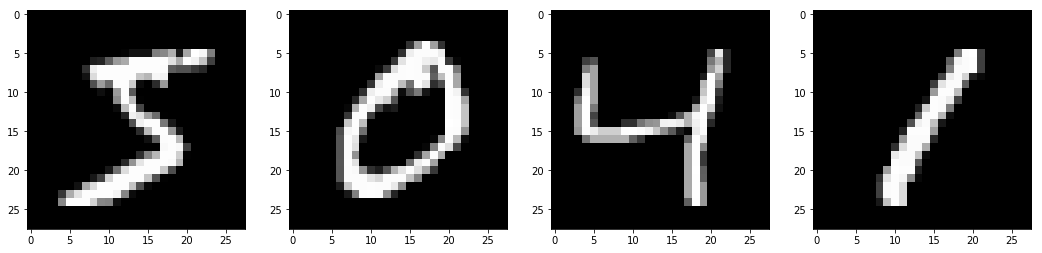

In [3]:
# visualize the 4 first mnist images before shuffling the pixels
plt.figure(figsize=(18,18))
for i in range(0,4):
    plt.subplot(1,4,(i+1))
    plt.imshow((X_train[i,:,:,0]),cmap="gray")
    #plt.axis('off')
print('true label: ',np.argmax(Y_train,axis=1)[0:4])

In [4]:
# function to shuffle the pixel order within an image
# used to shuffel the pixels of all mnist images in the same manner
def shuffel_pixels(idx, data):
  data_new=np.zeros((data.shape))
  for i,img in enumerate(data):
    data_new[i] = img.flatten()[idx].reshape((28,28,1))
  return data_new

np.random.seed(42)
shuffel_idx = np.random.permutation(np.arange(28*28))
X_train_shuffle = shuffel_pixels(shuffel_idx, X_train)
X_val_shuffle = shuffel_pixels(shuffel_idx, X_val)
X_test_shuffle = shuffel_pixels(shuffel_idx, X_test)

true label:  [5 0 4 1]


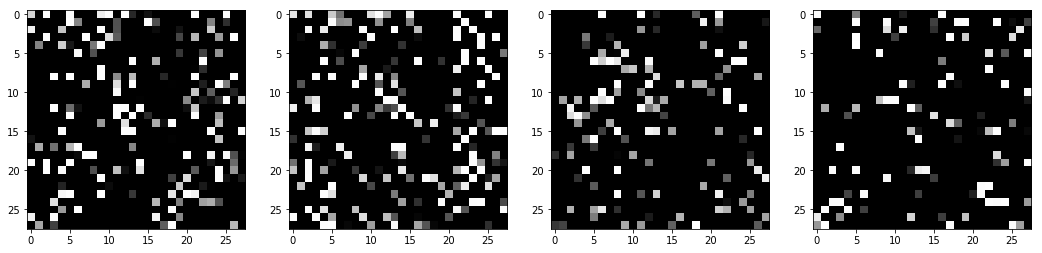

In [5]:
# visualize the 4 first mnist images after shuffling the pixels
plt.figure(figsize=(18,18))
for i in range(0,4):
    plt.subplot(1,4,(i+1))
    plt.imshow((X_train_shuffle[i,:,:,0]),cmap="gray")
print('true label: ',np.argmax(Y_train,axis=1)[0:4])


## fcNN as classification model for MNIST data

* Use a fcNN with 2 hidden layers as classification model
* train it once on the original train data and check the performance on the original test data
* train it once on the shuffeled train data and check the performance on the accordingly shuffled test data

In [6]:
# prepare data for fcNN - we need a vector as input

# first do it for original data
X_train_flat = X_train.reshape([X_train.shape[0], 784])
X_val_flat = X_val.reshape([X_val.shape[0], 784])
X_test_flat = X_test.reshape([X_test.shape[0], 784])

# then do it for the shuffled data
X_train_shuffle_flat = X_train_shuffle.reshape([X_train_shuffle.shape[0], 784])
X_val_shuffle_flat = X_val_shuffle.reshape([X_val_shuffle.shape[0], 784])
X_test_shuffle_flat = X_test_shuffle.reshape([X_test_shuffle.shape[0], 784])


### Train the fcNN on the original data

In [7]:
# check the shape
X_train_flat.shape,Y_train.shape,X_val_flat.shape,Y_val.shape

((50000, 784), (50000, 10), (10000, 784), (10000, 10))

In [8]:
# define fcNN with 2 hidden layers
model = Sequential()

model.add(Dense(100, batch_input_shape=(None, 784)))
model.add(Activation('relu'))
model.add(Dense(50))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))

# compile model and intitialize weights
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [9]:
# summarize model along with number of model weights
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
activation_2 (Activation)    (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                510       
_________________________________________________________________
activation_3 (Activation)    (None, 10)                0         
Total params: 84,060
Trainable params: 84,060
Non-trainable params: 0
_________________________________________________________________


In [10]:
# train the model
history=model.fit(X_train_flat, Y_train, 
                  batch_size=128, 
                  epochs=10,
                  verbose=2, 
                  validation_data=(X_val_flat, Y_val)
                 )

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
 - 1s - loss: 0.3871 - acc: 0.8925 - val_loss: 0.1658 - val_acc: 0.9538
Epoch 2/10
 - 1s - loss: 0.1545 - acc: 0.9548 - val_loss: 0.1298 - val_acc: 0.9636
Epoch 3/10
 - 1s - loss: 0.1116 - acc: 0.9676 - val_loss: 0.1070 - val_acc: 0.9690
Epoch 4/10
 - 1s - loss: 0.0868 - acc: 0.9747 - val_loss: 0.0958 - val_acc: 0.9725
Epoch 5/10
 - 1s - loss: 0.0713 - acc: 0.9792 - val_loss: 0.0961 - val_acc: 0.9714
Epoch 6/10
 - 1s - loss: 0.0566 - acc: 0.9835 - val_loss: 0.0881 - val_acc: 0.9744
Epoch 7/10
 - 1s - loss: 0.0493 - acc: 0.9854 - val_loss: 0.0853 - val_acc: 0.9732
Epoch 8/10
 - 1s - loss: 0.0417 - acc: 0.9876 - val_loss: 0.0834 - val_acc: 0.9762
Epoch 9/10
 - 1s - loss: 0.0340 - acc: 0.9898 - val_loss: 0.0920 - val_acc: 0.9734
Epoch 10/10
 - 1s - loss: 0.0292 - acc: 0.9912 - val_loss: 0.0841 - val_acc: 0.9766


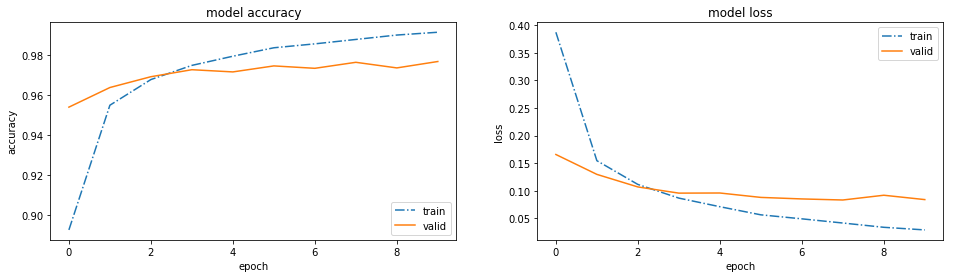

In [18]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(16,4))
plt.subplot(1,2,(1))
plt.plot(history.history['acc'],linestyle='-.')
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,(2))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')

plt.savefig('ch02_13.pdf')

#### Prediction on the original test set after training on original data

Use the fcNN that was trained on the original data for prediction of the mnist images in the original test data set. 
Determine the confusion matrix and the accuracy for evaluating the classification performance.


In [12]:
pred=model.predict(X_test_flat)
print(confusion_matrix(np.argmax(Y_test,axis=1),np.argmax(pred,axis=1)))
acc_fc_orig = np.sum(np.argmax(Y_test,axis=1)==np.argmax(pred,axis=1))/len(pred)
print("Acc_fc_orig_flat = " , acc_fc_orig)

[[ 971    0    1    1    0    0    1    3    3    0]
 [   0 1120    3    2    0    1    5    1    3    0]
 [   7    0  994    3    2    0    7   11    7    1]
 [   0    0    6  975    1   10    0   10    3    5]
 [   2    0    5    1  956    0    5    3    1    9]
 [   3    1    0    4    1  866    6    1    5    5]
 [   8    2    2    1    3    3  938    0    1    0]
 [   0    4    8    0    1    0    0 1007    0    8]
 [   6    0    1    4    4    5    3    4  940    7]
 [   3    2    0    3    7    4    0    5    0  985]]
Acc_fc_orig_flat =  0.9752


### Train the fcNN on the shuffled data

In [13]:
# check the shape
X_train_shuffle_flat.shape,Y_train.shape,X_val_shuffle_flat.shape,Y_val.shape

((50000, 784), (50000, 10), (10000, 784), (10000, 10))

In [0]:
# define fcNN with 2 hidden layers
model = Sequential()

model.add(Dense(100, batch_input_shape=(None, 784)))
model.add(Activation('relu'))
model.add(Dense(50))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))

# compile model and intitialize weights
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [15]:
# train the model
history=model.fit(X_train_shuffle_flat, Y_train, 
                  batch_size=128, 
                  epochs=10,
                  verbose=2, 
                  validation_data=(X_val_shuffle_flat, Y_val)
                 )

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
 - 3s - loss: 0.3994 - acc: 0.8869 - val_loss: 0.1891 - val_acc: 0.9489
Epoch 2/10
 - 2s - loss: 0.1636 - acc: 0.9524 - val_loss: 0.1457 - val_acc: 0.9576
Epoch 3/10
 - 2s - loss: 0.1175 - acc: 0.9645 - val_loss: 0.1124 - val_acc: 0.9666
Epoch 4/10
 - 2s - loss: 0.0899 - acc: 0.9726 - val_loss: 0.1029 - val_acc: 0.9703
Epoch 5/10
 - 2s - loss: 0.0730 - acc: 0.9779 - val_loss: 0.0973 - val_acc: 0.9732
Epoch 6/10
 - 2s - loss: 0.0588 - acc: 0.9820 - val_loss: 0.0881 - val_acc: 0.9743
Epoch 7/10
 - 2s - loss: 0.0476 - acc: 0.9858 - val_loss: 0.0868 - val_acc: 0.9744
Epoch 8/10
 - 2s - loss: 0.0412 - acc: 0.9873 - val_loss: 0.0851 - val_acc: 0.9760
Epoch 9/10
 - 2s - loss: 0.0328 - acc: 0.9900 - val_loss: 0.0964 - val_acc: 0.9730
Epoch 10/10
 - 2s - loss: 0.0266 - acc: 0.9922 - val_loss: 0.0916 - val_acc: 0.9724


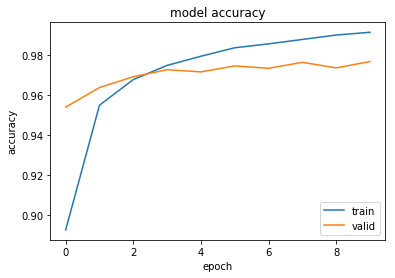

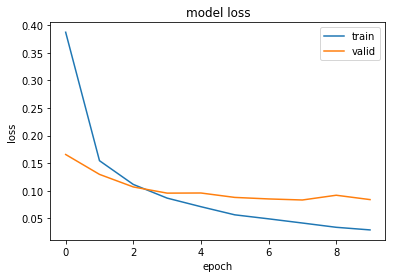

In [19]:
# plot the development of the accuracy and loss during training
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

#### Prediction on the shuffled test set after training on the shuffled data

Use the fcNN that was trained on the shuffled data for prediction of the mnist images in the test data set. Determine the confusion matrix and the accuracy for evaluating the classification performance.


In [17]:
pred=model.predict(X_test_shuffle_flat)
print(confusion_matrix(np.argmax(Y_test,axis=1),np.argmax(pred,axis=1)))
acc_fc_shuffled = np.sum(np.argmax(Y_test,axis=1)==np.argmax(pred,axis=1))/len(pred)
print("Acc_fc_shuffled_flat = " , acc_fc_shuffled)

[[ 971    1    0    2    0    0    2    0    3    1]
 [   0 1126    2    1    0    1    2    0    3    0]
 [   3    6  992    9    2    0    4    5   11    0]
 [   0    0    0  997    0    1    0    4    4    4]
 [   1    1    1    1  956    0    4    2    2   14]
 [   2    0    0   12    1  864    7    3    3    0]
 [   4    2    1    1    6    4  937    0    3    0]
 [   0    9    8    6    1    0    0  988    4   12]
 [   3    0    3    7    2    2    3    3  947    4]
 [   1    6    0   10   11    1    0    3    6  971]]
Acc_fc_shuffled_flat =  0.9749


### Note that in a fcNN the order of the data does not matter. The performace is the same when the original data is used for training and test or if the data was shuffled befor doing the training and test. In both cases the accuracy is around 0.975. 

## CNN as classification model for MNIST data

* Use a CNN with 2 convolution blocks and 2 fully connected layers as classification model
* train it once on the original train data and check the performance on the original test data
* train it once on the shuffeled train data and check the performance on the accordingly shuffled test data

### Train the CNN on the original data

In [18]:
# check the shape of the orginal data
# we need matrices as input
X_train.shape,Y_train.shape,X_val.shape,Y_val.shape

((50000, 28, 28, 1), (50000, 10), (10000, 28, 28, 1), (10000, 10))

In [0]:
# here we define  hyperparameter of the CNN
batch_size = 128
nb_classes = 10
img_rows, img_cols = 28, 28
kernel_size = (3, 3)
input_shape = (img_rows, img_cols, 1)
pool_size = (2, 2)

In [0]:
# define CNN with 2 convolution blocks and 2 fully connected layers
model = Sequential()

model.add(Convolution2D(8,kernel_size,padding='same',input_shape=input_shape))
model.add(Activation('relu'))
model.add(Convolution2D(8, kernel_size,padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Convolution2D(16, kernel_size,padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(16,kernel_size,padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Flatten())
model.add(Dense(40))
model.add(Activation('relu'))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

# compile model and intitialize weights
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [21]:
# summarize model along with number of model weights
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 8)         80        
_________________________________________________________________
activation_7 (Activation)    (None, 28, 28, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 8)         584       
_________________________________________________________________
activation_8 (Activation)    (None, 28, 28, 8)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 16)        1168      
_________________________________________________________________
activation_9 (Activation)    (None, 14, 14, 16)        0         
__________

In [22]:
# train the model
history=model.fit(X_train, Y_train, 
                  batch_size=128, 
                  epochs=10,
                  verbose=2, 
                  validation_data=(X_val, Y_val)
                 )

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
 - 8s - loss: 0.3608 - acc: 0.8941 - val_loss: 0.1169 - val_acc: 0.9644
Epoch 2/10
 - 5s - loss: 0.0919 - acc: 0.9714 - val_loss: 0.0642 - val_acc: 0.9824
Epoch 3/10
 - 5s - loss: 0.0640 - acc: 0.9799 - val_loss: 0.0604 - val_acc: 0.9832
Epoch 4/10
 - 5s - loss: 0.0491 - acc: 0.9849 - val_loss: 0.0496 - val_acc: 0.9872
Epoch 5/10
 - 5s - loss: 0.0401 - acc: 0.9874 - val_loss: 0.0527 - val_acc: 0.9853
Epoch 6/10
 - 5s - loss: 0.0335 - acc: 0.9896 - val_loss: 0.0454 - val_acc: 0.9882
Epoch 7/10
 - 5s - loss: 0.0294 - acc: 0.9903 - val_loss: 0.0451 - val_acc: 0.9873
Epoch 8/10
 - 5s - loss: 0.0252 - acc: 0.9915 - val_loss: 0.0417 - val_acc: 0.9894
Epoch 9/10
 - 5s - loss: 0.0211 - acc: 0.9931 - val_loss: 0.0436 - val_acc: 0.9873
Epoch 10/10
 - 5s - loss: 0.0189 - acc: 0.9934 - val_loss: 0.0392 - val_acc: 0.9895


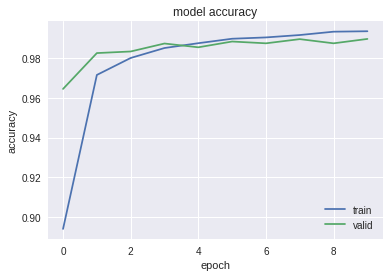

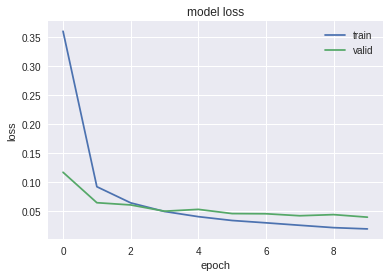

In [23]:
# plot the development of the accuracy and loss during training
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

#### Prediction on the test set after training on original data

Use the CNN that was trained on the original data for prediction of the mnist images in the test data set. Determine the confusion matrix and the accuracy for evaluating the classification performance.


In [24]:
pred=model.predict(X_test)
print(confusion_matrix(np.argmax(Y_test,axis=1),np.argmax(pred,axis=1)))
acc_fc_orig = np.sum(np.argmax(Y_test,axis=1)==np.argmax(pred,axis=1))/len(pred)
print("Acc_fc_orig = " , acc_fc_orig)

[[ 975    1    0    0    0    0    2    1    1    0]
 [   0 1132    1    0    0    1    0    1    0    0]
 [   3    3 1022    0    0    0    0    4    0    0]
 [   2    0    1  998    0    4    0    2    3    0]
 [   0    0    2    0  976    0    2    0    0    2]
 [   2    0    0    3    0  883    4    0    0    0]
 [   2    1    2    0    1    1  951    0    0    0]
 [   0    4    5    1    0    0    0 1014    1    3]
 [   7    0    2    1    0    2    0    1  959    2]
 [   0    1    1    0    8    8    0    2    4  985]]
Acc_fc_orig =  0.9895


### Train the CNN on the shuffled data

In [25]:
# check the shape of the shuffled data
# we need matrices as input
X_train_shuffle.shape,Y_train.shape,X_val_shuffle.shape,Y_val.shape

((50000, 28, 28, 1), (50000, 10), (10000, 28, 28, 1), (10000, 10))

In [0]:
# define CNN with 2 convolution blocks and 2 fully connected layers  
model = Sequential()

model.add(Convolution2D(8,kernel_size,padding='same',input_shape=input_shape))
model.add(Activation('relu'))
model.add(Convolution2D(8, kernel_size,padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Convolution2D(16, kernel_size,padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(16,kernel_size,padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Flatten())
model.add(Dense(40))
model.add(Activation('relu'))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

# compile model and intitialize weights
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [27]:
# train the model
history=model.fit(X_train_shuffle, Y_train, 
                  batch_size=128, 
                  epochs=10,
                  verbose=2, 
                  validation_data=(X_val_shuffle, Y_val)
                 )

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
 - 6s - loss: 0.7360 - acc: 0.7631 - val_loss: 0.3438 - val_acc: 0.8958
Epoch 2/10
 - 5s - loss: 0.3351 - acc: 0.8988 - val_loss: 0.2658 - val_acc: 0.9235
Epoch 3/10
 - 5s - loss: 0.2638 - acc: 0.9188 - val_loss: 0.2191 - val_acc: 0.9363
Epoch 4/10
 - 5s - loss: 0.2216 - acc: 0.9329 - val_loss: 0.2007 - val_acc: 0.9382
Epoch 5/10
 - 5s - loss: 0.1919 - acc: 0.9412 - val_loss: 0.1953 - val_acc: 0.9427
Epoch 6/10
 - 5s - loss: 0.1712 - acc: 0.9467 - val_loss: 0.1786 - val_acc: 0.9464
Epoch 7/10
 - 5s - loss: 0.1523 - acc: 0.9530 - val_loss: 0.1725 - val_acc: 0.9456
Epoch 8/10
 - 5s - loss: 0.1366 - acc: 0.9575 - val_loss: 0.1648 - val_acc: 0.9520
Epoch 9/10
 - 5s - loss: 0.1253 - acc: 0.9603 - val_loss: 0.1737 - val_acc: 0.9473
Epoch 10/10
 - 5s - loss: 0.1141 - acc: 0.9644 - val_loss: 0.1520 - val_acc: 0.9555


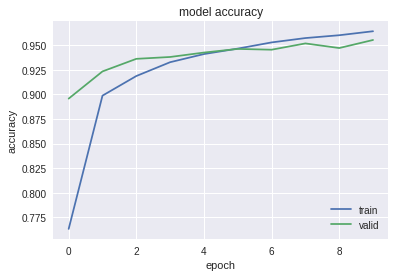

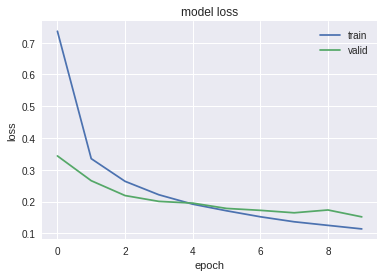

In [28]:
# plot the development of the accuracy and loss during training
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

#### Prediction on the test set after training on the shuffled data

Use the CNN that was trained on the shuffled data for prediction of the mnist images in the test data set. Determine the confusion matrix and the accuracy for evaluating the classification performance.


In [29]:
pred=model.predict(X_test_shuffle)
print(confusion_matrix(np.argmax(Y_test,axis=1),np.argmax(pred,axis=1)))
acc_fc_shuffled = np.sum(np.argmax(Y_test,axis=1)==np.argmax(pred,axis=1))/len(pred)
print("Acc_fc_shuffled = " , acc_fc_shuffled)

[[ 964    0    6    2    0    0    3    1    2    2]
 [   0 1122    5    1    0    1    1    2    3    0]
 [  10    1  980   13    1    1    1    8   15    2]
 [   1    0    5  977    0   10    0    6    8    3]
 [   4    0    9    0  904    1    7   10    7   40]
 [  11    1    1   20    0  839    6    2    7    5]
 [  17    3    7    0    2    8  915    2    4    0]
 [   5    4   13    4    2    0    0  972    3   25]
 [   9    0    8   20    3    8    8    5  901   12]
 [   4    2    3   10   11    6    0   11    6  956]]
Acc_fc_shuffled =  0.953


# Conclusion

### In a CNN the order of the data does matter, the performace for the original images and for the shuffled are the different! The CNN performs better on the original data. The CNN trained on the original data achieved an accuracy of  0.99, but the same CNN trained on the shuffled version of the data achieved only 0.95 accuracy. 

### This was not the case when a fcNN was used - here the performance did not change if the data was shuffled. The fcNN achieved an accuracy of 0.975 regardless if the data was shuffled or not. 

### It is worth to note that on the original data the CNN achieved with "only" 35962 model weights a higher accuracy (0.99) than the fcNN with 84000 model weights that achieved a smaller accuray (0.975)
